# 09. Autoencoder for Anomaly Detection

Deep learning approach using reconstruction error:
- Train autoencoder to reconstruct "normal" patterns
- High reconstruction error = anomaly

**Architecture:**
```
Input → Hidden(32) → Encoding(8) → Hidden(32) → Output
```

**Detectors:**
- `AutoencoderDetector` - tender-level
- `AggregatedAutoencoder` - buyer/supplier/pair level (recommended)

In [49]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path

from src.data_loader import load_tenders, load_buyers, load_suppliers
from src.detectors import AutoencoderDetector, AggregatedAutoencoder, AggregatedPyOD

# Create output directory
Path('../results/figures/autoencoder').mkdir(parents=True, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-01-31 12:28:36


## 1. Load Data

In [50]:
# Configuration
YEARS = [2022, 2023, 2024, 2025]  # Start with one year for testing
SAMPLE_FRAC = 1.0  # 10% sample for faster iteration

print(f"Loading data for years: {YEARS}...")
tenders = load_tenders(years=YEARS, sample_frac=SAMPLE_FRAC)
buyers = load_buyers()
suppliers = load_suppliers()

print(f"\nDataset:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Buyers: {len(buyers):,}")
print(f"  Suppliers: {len(suppliers):,}")

Loading data for years: [2022, 2023, 2024, 2025]...
Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Sampled to 12,877,960 records (100%)
Loaded buyers: 35,995
Loaded suppliers: 358,376

Dataset:
  Tenders: 12,877,960
  Buyers: 35,995
  Suppliers: 358,376


## 2. Aggregated Autoencoder (Recommended)

Detects anomalous buyers, suppliers, and pairs based on behavioral patterns.

In [51]:
# Initialize detector
ae_detector = AggregatedAutoencoder(
    encoding_dim=4,
    hidden_dim=16,
    epochs=30,
    batch_size=256,
    contamination=0.05,
)

  Note: CUDA not compatible, using CPU


In [52]:
# Detect anomalous buyers
buyer_results = ae_detector.detect_buyers(tenders, buyers)

AggregatedAutoencoder: Detecting anomalous BUYERS...
  Device: cpu
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995
    Epoch 10/30, Loss: 5.456748
    Epoch 20/30, Loss: 4.889359
    Epoch 30/30, Loss: 4.754826
  Anomalies: 1,800 (5.0%)


In [53]:
# Detect anomalous suppliers
supplier_results = ae_detector.detect_suppliers(tenders)

AggregatedAutoencoder: Detecting anomalous SUPPLIERS...
  Device: cpu
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377
    Epoch 10/30, Loss: 0.052539
    Epoch 20/30, Loss: 0.051744
    Epoch 30/30, Loss: 0.051507
  Anomalies: 17,919 (5.0%)


In [54]:
# Detect anomalous pairs
pair_results = ae_detector.detect_pairs(tenders, min_contracts=3)

AggregatedAutoencoder: Detecting anomalous PAIRS...
  Device: cpu
  Computing pair features from tenders...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
    Epoch 10/30, Loss: 0.280946
    Epoch 20/30, Loss: 0.267446
    Epoch 30/30, Loss: 0.266752
  Anomalies: 45,814 (5.0%)


In [55]:
# Summary
print("\n" + "="*60)
print("AUTOENCODER SUMMARY")
print("="*60)

for name, summary in ae_detector.summary().items():
    print(f"\n{name.upper()}:")
    print(summary.to_string(index=False))


AUTOENCODER SUMMARY

BUYERS:
     metric        value
      total 35995.000000
  anomalies  1800.000000
anomaly_pct     5.000695
   critical     1.000000
       high     0.000000

SUPPLIERS:
     metric         value
      total 358377.000000
  anomalies  17919.000000
anomaly_pct      5.000042
   critical      1.000000
       high      1.000000

PAIRS:
     metric         value
      total 916278.000000
  anomalies  45814.000000
anomaly_pct      5.000011
   critical      3.000000
       high      9.000000


## 3. Score Distribution

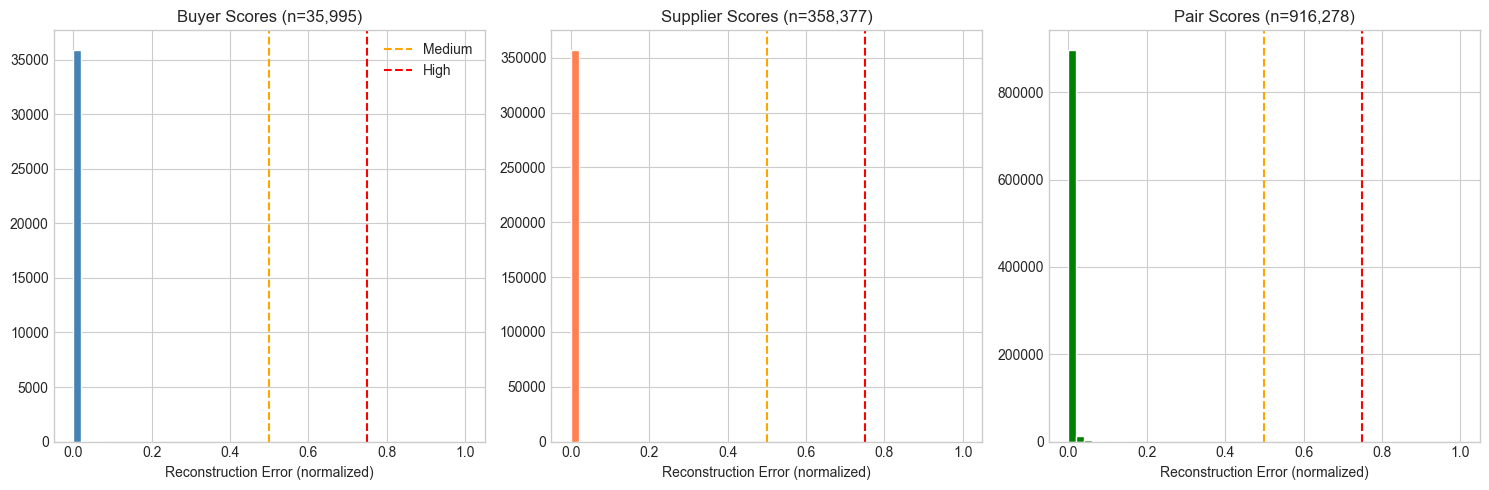

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Buyers
axes[0].hist(buyer_results['score'], bins=50, color='steelblue', edgecolor='white')
axes[0].axvline(x=0.5, color='orange', linestyle='--', label='Medium')
axes[0].axvline(x=0.75, color='red', linestyle='--', label='High')
axes[0].set_title(f'Buyer Scores (n={len(buyer_results):,})')
axes[0].set_xlabel('Reconstruction Error (normalized)')
axes[0].legend()

# Suppliers
axes[1].hist(supplier_results['score'], bins=50, color='coral', edgecolor='white')
axes[1].axvline(x=0.5, color='orange', linestyle='--')
axes[1].axvline(x=0.75, color='red', linestyle='--')
axes[1].set_title(f'Supplier Scores (n={len(supplier_results):,})')
axes[1].set_xlabel('Reconstruction Error (normalized)')

# Pairs
if len(pair_results) > 0:
    axes[2].hist(pair_results['score'], bins=50, color='green', edgecolor='white')
    axes[2].axvline(x=0.5, color='orange', linestyle='--')
    axes[2].axvline(x=0.75, color='red', linestyle='--')
    axes[2].set_title(f'Pair Scores (n={len(pair_results):,})')
    axes[2].set_xlabel('Reconstruction Error (normalized)')

plt.tight_layout()
plt.savefig('../results/figures/autoencoder/score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Top Anomalies

In [57]:
# Top anomalous buyers
print("TOP 10 ANOMALOUS BUYERS:")
top_buyers = buyer_results.nlargest(10, 'score')[['buyer_id', 'score', 'risk_level', 'single_bidder_rate', 'total_value']]
top_buyers['total_value'] = top_buyers['total_value'] / 1e6  # Convert to millions
display(top_buyers)

TOP 10 ANOMALOUS BUYERS:


,buyer_id,score,risk_level,single_bidder_rate,total_value
34610,45522091,1.000000,critical,0.000000,43.000000
33100,35800187,0.340118,low,0.000000,1.993022
30727,13302872,0.338821,low,0.000000,1.613630
31818,40882649,0.141616,low,0.000000,0.765800
32322,36205405,0.122142,low,0.000000,0.258000
32123,26639202,0.090788,low,0.250000,0.262000
30921,44030626,0.076286,low,0.666667,0.428028
34411,43057338,0.071483,low,0.000000,0.216000
29278,40223226,0.071427,low,0.000000,0.418388
32566,31693489,0.071416,low,0.000000,2.332498


In [58]:
# Top anomalous suppliers
print("TOP 10 ANOMALOUS SUPPLIERS:")
top_suppliers = supplier_results.nlargest(10, 'score')[['supplier_id', 'score', 'risk_level', 'total_awards', 'total_value']]
top_suppliers['total_value'] = top_suppliers['total_value'] / 1e6
display(top_suppliers)

TOP 10 ANOMALOUS SUPPLIERS:


,supplier_id,score,risk_level,total_awards,total_value
165695,2900722618,1.000000,critical,1,5.971266
48239,44304371,0.895278,high,1,1.779842
103912,45299284,0.633945,medium,1,0.120000
181076,40938984,0.457294,low,2,67.845600
39629,3294810761,0.369509,low,1,0.600000
169278,3104733033,0.344314,low,1,0.474151
138396,00376403,0.328172,low,3,4774.160991
304789,43005206,0.324347,low,1,0.199000
62600,38329477,0.275524,low,1,0.980000
240668,34326561,0.245803,low,2,4.030459


In [59]:
# Top anomalous pairs
if len(pair_results) > 0:
    print("TOP 10 ANOMALOUS PAIRS:")
    top_pairs = pair_results.nlargest(10, 'score')[['buyer_id', 'supplier_id', 'score', 'contracts_count', 'exclusivity_buyer', 'exclusivity_supplier']]
    display(top_pairs)

TOP 10 ANOMALOUS PAIRS:


,buyer_id,supplier_id,score,contracts_count,exclusivity_buyer,exclusivity_supplier
446459,26641920,88888888,1.000000,1353,0.994853,0.020793
705541,38426944,88888888,0.928684,4677,0.902373,0.071875
176654,32855689,43937020,0.901117,588,0.965517,0.998302
643399,24973658,88888888,0.875452,1828,0.998362,0.028092
261330,00689384,19389532,0.778553,3,1.000000,1.000000
193314,43811869,88888888,0.776942,2122,0.930294,0.032611
814500,41384763,3055412354,0.773177,3,1.000000,1.000000
113149,3165704792,2039814704,0.769121,3,1.000000,1.000000
739460,08464162,88888888,0.768520,1321,0.943571,0.020301
782249,43955068,43955068,0.766498,4,1.000000,1.000000


## 5. Comparison with PyOD (LOF)

In [60]:
# Run LOF for comparison
lof_detector = AggregatedPyOD(algorithm='lof', contamination=0.05)
lof_buyer_results = lof_detector.detect_buyers(tenders, buyers)

AggregatedPyOD (LOF): Detecting anomalous BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995
  Anomalies: 1,800 (5.0%)


In [61]:
# Compare AE vs LOF on buyers
comparison = buyer_results[['buyer_id', 'score', 'anomaly']].merge(
    lof_buyer_results[['buyer_id', 'score', 'anomaly']],
    on='buyer_id',
    suffixes=('_ae', '_lof')
)

# Correlation
score_corr = comparison['score_ae'].corr(comparison['score_lof'])

# Agreement
ae_anomalies = set(comparison[comparison['anomaly_ae'] == 1]['buyer_id'])
lof_anomalies = set(comparison[comparison['anomaly_lof'] == 1]['buyer_id'])
overlap = len(ae_anomalies & lof_anomalies)
jaccard = overlap / len(ae_anomalies | lof_anomalies) if len(ae_anomalies | lof_anomalies) > 0 else 0

print("AUTOENCODER vs LOF (Buyers):")
print(f"  Score correlation: {score_corr:.3f}")
print(f"  Jaccard similarity: {jaccard:.3f}")
print(f"  Overlap: {overlap} / {len(ae_anomalies)} AE, {len(lof_anomalies)} LOF")

AUTOENCODER vs LOF (Buyers):
  Score correlation: -0.001
  Jaccard similarity: 0.071
  Overlap: 240 / 1800 AE, 1800 LOF


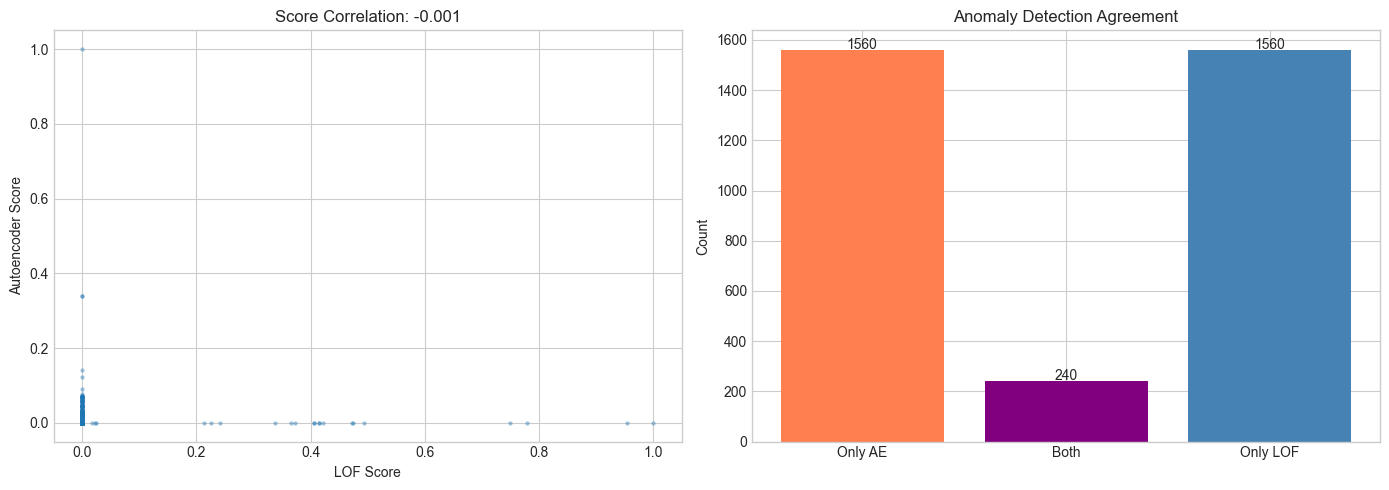

In [62]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(comparison['score_lof'], comparison['score_ae'], alpha=0.3, s=5)
axes[0].set_xlabel('LOF Score')
axes[0].set_ylabel('Autoencoder Score')
axes[0].set_title(f'Score Correlation: {score_corr:.3f}')

# Venn-style breakdown
only_ae = len(ae_anomalies - lof_anomalies)
only_lof = len(lof_anomalies - ae_anomalies)
both = overlap

labels = ['Only AE', 'Both', 'Only LOF']
sizes = [only_ae, both, only_lof]
colors = ['coral', 'purple', 'steelblue']

axes[1].bar(labels, sizes, color=colors)
axes[1].set_ylabel('Count')
axes[1].set_title('Anomaly Detection Agreement')
for i, v in enumerate(sizes):
    axes[1].text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.savefig('../results/figures/autoencoder/ae_vs_lof.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Tender-Level Autoencoder (Optional)

Note: This is slower and less effective than aggregated level for this dataset.

In [63]:
# Uncomment to run tender-level autoencoder (takes longer)

# tender_ae = AutoencoderDetector(
#     encoding_dim=8,
#     hidden_dim=32,
#     epochs=20,
#     contamination=0.05,
# )

# tender_results = tender_ae.fit_detect(
#     tenders,
#     buyers_df=buyers,
#     suppliers_df=suppliers,
#     sample_size=100_000  # Train on sample for speed
# )

# print(tender_ae.summary())

## 7. Conclusions

In [64]:
print("="*60)
print("AUTOENCODER ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset: {len(tenders):,} tenders")

print(f"\nAggregated Autoencoder Results:")
print(f"  Buyers: {buyer_results['anomaly'].sum():,} anomalies ({buyer_results['anomaly'].mean()*100:.1f}%)")
print(f"  Suppliers: {supplier_results['anomaly'].sum():,} anomalies ({supplier_results['anomaly'].mean()*100:.1f}%)")
if len(pair_results) > 0:
    print(f"  Pairs: {pair_results['anomaly'].sum():,} anomalies ({pair_results['anomaly'].mean()*100:.1f}%)")

print(f"\nComparison with LOF:")
print(f"  Score correlation: {score_corr:.3f}")
print(f"  Jaccard similarity: {jaccard:.3f}")

if score_corr < 0.3:
    print(f"\n  → LOW correlation: AE and LOF detect DIFFERENT anomalies")
    print(f"  → Include BOTH in ensemble for comprehensive detection")
elif score_corr < 0.6:
    print(f"\n  → MODERATE correlation: Some overlap, still complementary")
else:
    print(f"\n  → HIGH correlation: Methods detect similar anomalies")

print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

AUTOENCODER ANALYSIS SUMMARY

Dataset: 12,877,960 tenders

Aggregated Autoencoder Results:
  Buyers: 1,800 anomalies (5.0%)
  Suppliers: 17,919 anomalies (5.0%)
  Pairs: 45,814 anomalies (5.0%)

Comparison with LOF:
  Score correlation: -0.001
  Jaccard similarity: 0.071

  → LOW correlation: AE and LOF detect DIFFERENT anomalies
  → Include BOTH in ensemble for comprehensive detection

Completed: 2026-01-31 12:32:52
